# 1) Read a data file with coordinates and mass of a number of small bodies.
# 2) Split the ring in the (0.97 AU:1.03 AU) range into Nbin bins.
# 3) Then, compute the surface density for each subring

## To avoid a statistical skew due to the value of Nbin chosen, we compute this for different number of bins in the range 15-25.

# 4) Fit a curves that describe the material distribution. The functions to fit are:

##      a) a polynomial
##      b) a trigonometric function
##      c) Gaussians overlapping

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

#Define some parameters and constants
nsimulations = ['21']
sdlist = []
amin = 0.98
amax = 1.02
factor = 8887.33592610598 #Convert surface density from M_sun AU^-2 to g cm^-2

#Open and read the data file, and create the Data Frame
inputfile = "simulacion21/element.out"
df = pd.read_csv(inputfile, skiprows=3, delim_whitespace=True, index_col=None)
df.reset_index(level=0, inplace=True)        

dffilter = df[(df['a'] > 0.98) & (df['a'] < 1.02)]

#Create a new Data Frame (sd) with the surface density value for each bin
for nbins in range(15,26):
    #Add a column with the corresponding bin for semimajor axis a
    #df['binned a N='+str(nbins)] = pd.cut(df['a'], nbins, precision=5)
    df['binned a N='+str(nbins)] = pd.cut(dffilter['a'], nbins, precision=5)
    
    for group, frame in df.groupby('binned a N='+str(nbins)):
        totalmass = np.sum(frame['mass'])
        amingroup = group.left
        amaxgroup = group.right
        bin_area = np.pi*(np.power(amaxgroup,2) - np.power(amingroup,2))
        surface_density = factor * totalmass / bin_area
        sdlist.append([nbins, amingroup, amaxgroup, (amaxgroup+amingroup)/2, totalmass, bin_area, surface_density])

sdtemp = pd.DataFrame(sdlist, columns=['N_sim', 'a_min', 'a_max', 'avg a', 'total mass', 'bin area', 'surface density'])

sd = sdtemp[(sdtemp['a_min'] > amin) & (sdtemp['a_max'] < amax)]
#sd.head()
#print(sd)


/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


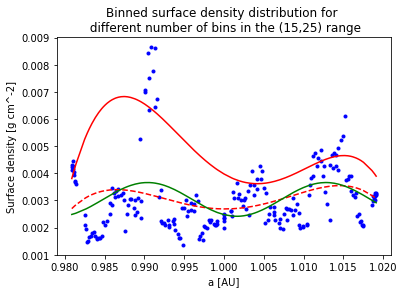

In [48]:
#Fit a curve to the data
def func1(x, a0, a1, a2, a3, a4, a5, a6, a7):#, a8, a9, a10, a11, a12):
    return a0 + a1*x + a2*np.power(x,2) + a3*np.power(x,3) + a4*np.power(x,4) + a5*np.power(x,5) + a6*np.power(x,6) + a7*np.power(x,7)#+ a8*np.power(x,8) + a9*np.power(x,9) + a10*np.power(x,10) + a11*np.power(x,11) + a12*np.power(x,12)

def func2(x, sa0, sa1, sb1, sc1, sa2, sb2, sc2):
    return sa0 + sa1*np.sin(sb1*x+sc1)# + sa2*np.sin(sb2*x+sc2)

#def func3(x, ea0, ea1, ea2, eb0, eb1, eb2, ec0, ec1, ec2):
#    return ea0*np.exp(-((x-ea1)/ea2)**2) + eb0*np.exp(-((x-eb1)/eb2)**2) + ec0*np.exp(-((x-ec1)/ec2)**2)
    
    
#Add some weight to x's with higher densities
n = len(sd['avg a'])
sigma = np.ones(n)*0.5
#sigma[np.abs(sd['surface density'] - 0.003) > 0.002] = 0.1
sigma[np.abs(sd['surface density']) > 0.004] = 0.1

popt0, pcov0 = curve_fit(func1, sd['avg a'], sd['surface density'])
popt1, pcov1 = curve_fit(func1, sd['avg a'], sd['surface density'], sigma=sigma, absolute_sigma=True)
popt2, pcov2 = curve_fit(func2, sd['avg a'], sd['surface density'])
#popt3, pcov3 = curve_fit(func3, sd['avg a'], sd['surface density'], p0=[1e-2,0.99,1.e-2, 4e-3,1.003,1.,5.e-3,1.013,1.], maxfev=3000, sigma=sigma, absolute_sigma=True)

#Build the plot and save it
xdata = sd.sort_values(by=['avg a'])['avg a']

plt.xlabel('a [AU]')
plt.ylabel('Surface density [g cm^-2]')
plt.title('Binned surface density distribution for \n different number of bins in the (15,25) range')

plt.plot(sd['avg a'], sd['surface density'], 'b.')
plt.plot(xdata, func1(xdata, *popt0), 'r--')
plt.plot(xdata, func1(xdata, *popt1), 'r-')
plt.plot(xdata, func2(xdata, *popt2), 'g-')
#plt.plot(xdata, func3(xdata, *popt3), 'c-')

plt.savefig('surface_density_profile.pdf', format='pdf')


In [21]:
sd['pandas_SMA_3'] = sd.iloc[:,6].rolling(window=3).mean()
sd.head()
#sd.drop(columns='pandas_SMA_3')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,N_sim,a_min,a_max,avg a,total mass,bin area,surface density,pandas_SMA_3
5,15,0.98680,0.99370,0.990250,1.905387e-08,0.042931,4.438226e-07,NaN
6,15,0.99370,1.00060,0.997150,1.075871e-08,0.043230,2.488689e-07,NaN
7,15,1.00060,1.00750,1.004050,1.462979e-08,0.043530,3.360886e-07,3.429267e-07
8,15,1.00750,1.01440,1.010950,1.779701e-08,0.043829,4.060583e-07,3.303386e-07
20,16,0.98464,0.99111,0.987875,1.930524e-08,0.040159,4.807164e-07,4.076211e-07


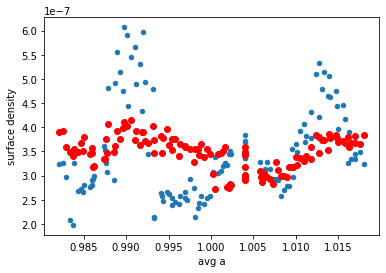

In [50]:
sd.plot(x='avg a', y='surface density', kind='scatter')
plt.scatter(sd['avg a'], sd['pandas_SMA_3'], color='r')

In [54]:
print(1.004-0.990)
print(1.013-1.004)

0.014000000000000012
0.008999999999999897


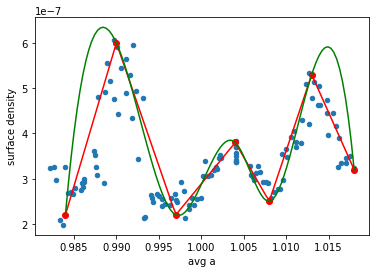

In [77]:
from scipy.interpolate import interp1d

puntos = pd.DataFrame(data={'x':[0.984, 0.990, 0.997, 1.004, 1.008, 1.013, 1.018], 'y':[2.2e-7, 6.0e-7, 2.2e-7, 3.8e-7, 2.5e-7, 5.3e-7, 3.2e-7]})

f1 = interp1d(puntos['x'], puntos['y'])
f2 = interp1d(puntos['x'], puntos['y'], kind='cubic')

xnew = np.linspace(0.984, 1.018, num=100)

sd.plot(x='avg a', y='surface density', kind='scatter')
plt.scatter(puntos['x'], puntos['y'], color='r')
plt.plot(xnew, f1(xnew), color='r')
plt.plot(xnew, f2(xnew), color='g')


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize

x = np.array(sd['avg a']).reshape(220,1)
y = np.array(sd['surface density']).reshape(220,1)


def tri_norm(x, *args):
    m1, m2, m3, s1, s2, s3, k1, k2, k3 = args
    ret = k1*scipy.stats.norm.pdf(x, loc=m1 ,scale=s1)
    ret += k2*scipy.stats.norm.pdf(x, loc=m2 ,scale=s2)
    ret += k3*scipy.stats.norm.pdf(x, loc=m3 ,scale=s3)
    return ret


params = [0.99, 1.004, 1.013, 1, 1, 1, 1, 1, 1]

popt3, pcov3 = scipy.optimize.curve_fit(tri_norm,x, y, p0=params)

print(popt3)

#plt.plot(x, y, 'o')
xx = np.linspace(np.min(x), np.max(x), 1000)
plt.plot(xx, tri_norm(xx, *popt3))
plt.show()

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned


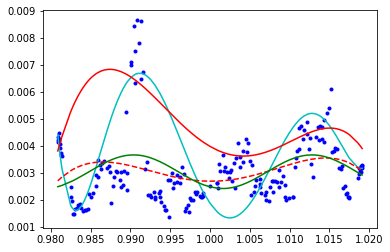

In [81]:
from scipy.interpolate import CubicSpline

# Sort sd data frame and only get one value of x for each occurrence
sorted = sd.sort_values(['avg a', 'surface density'], ascending = [True, False])

sd_clean = sorted.groupby('avg a').first().reset_index()

xdata = np.array(sd_clean['avg a'])
ydata = np.array(sd_clean['surface density'])


cs = CubicSpline(xdata, ydata)

#Add some weight to x's with higher densities
n = len(xdata)
sigmapoly = np.ones(n)*0.5
#sigma[np.abs(sd['surface density'] - 0.003) > 0.002] = 0.1
sigmapoly[np.abs(ydata) > 0.005] = 2


# fit regression line
regressionLineOrder = 8
regressionLine = np.polyfit(xdata, ydata, regressionLineOrder, w=sigmapoly)
p = np.poly1d(regressionLine)

#plt.figure(figsize=(20,10))
plt.plot(xdata, ydata, 'b.')
#plt.plot(xdata, cs(xdata), 'r--', label='Cubic spline')
plt.plot(xdata, p(xdata), 'c-')
plt.plot(xdata, func1(xdata, *popt0), 'r--')
plt.plot(xdata, func1(xdata, *popt1), 'r-')
plt.plot(xdata, func2(xdata, *popt2), 'g-')
#plt.plot(xdata, func3(xdata, *popt3), 'c-')

plt.savefig('surface_density_profile.pdf', format='pdf')


